# Selection of a location for a well

The task is to determine the location for a new oil well.

The selection usually consists of the following steps:
1. Gathering characteristics for wells in the selected region: estimating oil quality and reserve volumes
2. Building models to predict the amount of reserves in new wells
3. Selecting the wells with the highest value estimates
4. Identification of the region with the maximum total profit of the selected wells

In our case, we have synthetic data on three oil regions. For each of them 100 000 points with known characteristics and oil volume (in thousands of barrels) are selected. It is required to select the most promising region.

In [1]:
import math
import pandas as pd
import numpy as np
import seaborn as sb
import scipy.stats as st
import matplotlib.pyplot as plt
import statsmodels.api as sm

from scipy.stats import zscore
from scipy.stats import norm, lognorm
from scipy.stats import shapiro, kstest, anderson
# from scipy.stats import normaltest, kurtosis, skew

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import normalize, MinMaxScaler, Normalizer

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score

## Data preprocessing

In [2]:
try:
    geo_data_0 = pd.read_csv('geo_data_0.csv')
    geo_data_1 = pd.read_csv('geo_data_1.csv')
    geo_data_2 = pd.read_csv('geo_data_2.csv')
except:
    geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
    geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
    geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')    

In [3]:
geo_data_0

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
...,...,...,...,...,...
99995,DLsed,0.971957,0.370953,6.075346,110.744026
99996,QKivN,1.392429,-0.382606,1.273912,122.346843
99997,3rnvd,1.029585,0.018787,-1.348308,64.375443
99998,7kl59,0.998163,-0.528582,1.583869,74.040764


### Missing values

In [4]:
all_data = pd.concat([geo_data_0, geo_data_1, geo_data_2])
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       300000 non-null  object 
 1   f0       300000 non-null  float64
 2   f1       300000 non-null  float64
 3   f2       300000 non-null  float64
 4   product  300000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 13.7+ MB


Looks like there's no skips.

### Duplicates

In [5]:
len(all_data['id'].unique())

299951

There are a few repeats, though.

In [6]:
all_data[all_data['id'].duplicated()]

,id,f0,f1,f2,product
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
41724,bxg6G,-0.823752,0.546319,3.630479,93.007798
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
66136,74z30,1.084962,-0.312358,6.990771,127.643327
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
75715,Tdehs,0.112079,0.430296,3.218993,60.964018
90815,fiKDv,0.049883,0.841313,6.394613,137.346586
92341,TtcGQ,0.110711,1.022689,0.911381,101.318008
97785,bsk9y,0.378429,0.005837,0.160827,160.637302


In [7]:
all_data[all_data['id'] == 'HZww2']

,id,f0,f1,f2,product
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695


Strange case. The working hypothesis is that the identifiers were generated for the three tables separately, so they are repeated in different dataframes.

In [8]:
geo_data_0[geo_data_0['id'].duplicated()]

,id,f0,f1,f2,product
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
41724,bxg6G,-0.823752,0.546319,3.630479,93.007798
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
66136,74z30,1.084962,-0.312358,6.990771,127.643327
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
75715,Tdehs,0.112079,0.430296,3.218993,60.964018
90815,fiKDv,0.049883,0.841313,6.394613,137.346586
92341,TtcGQ,0.110711,1.022689,0.911381,101.318008
97785,bsk9y,0.378429,0.005837,0.160827,160.637302


In [9]:
geo_data_0[geo_data_0['id'] == 'HZww2']

,id,f0,f1,f2,product
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695


However, no. Even within a single data set, identifiers do not fulfill their function.

Since there is no indication by which one of them can be discarded, we leave the repetitions in the data.

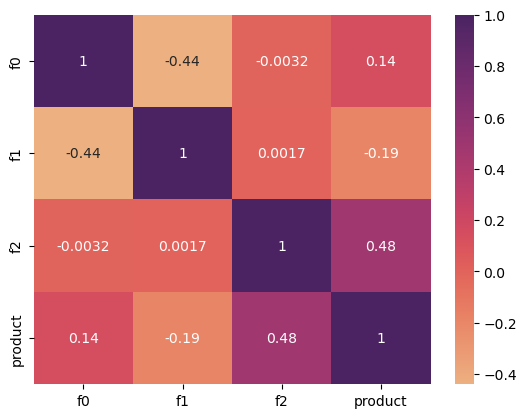

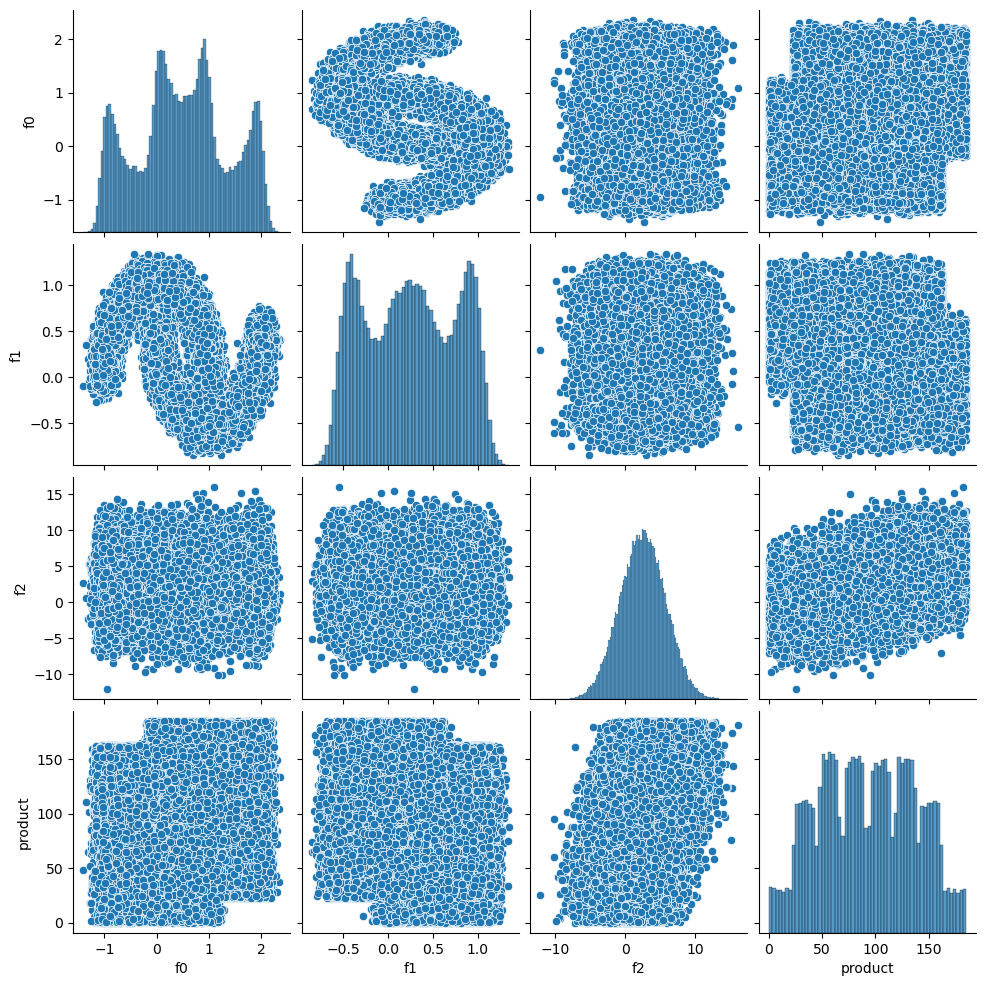

In [10]:
sb.heatmap(geo_data_0.drop('id', axis=1).corr(), cmap='flare', annot=True)
plt.show()
sb.pairplot(geo_data_0)
plt.show()

Some correlation can be traced only between f2 and product. But it is not high and we need both columns.

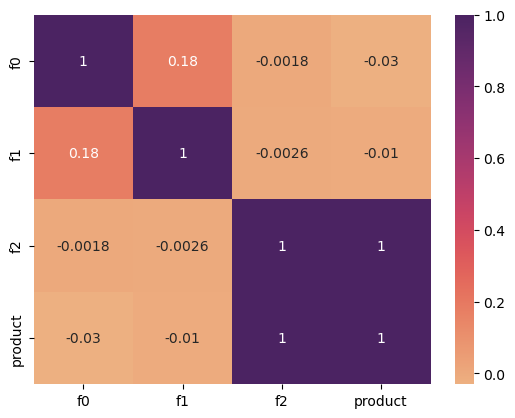

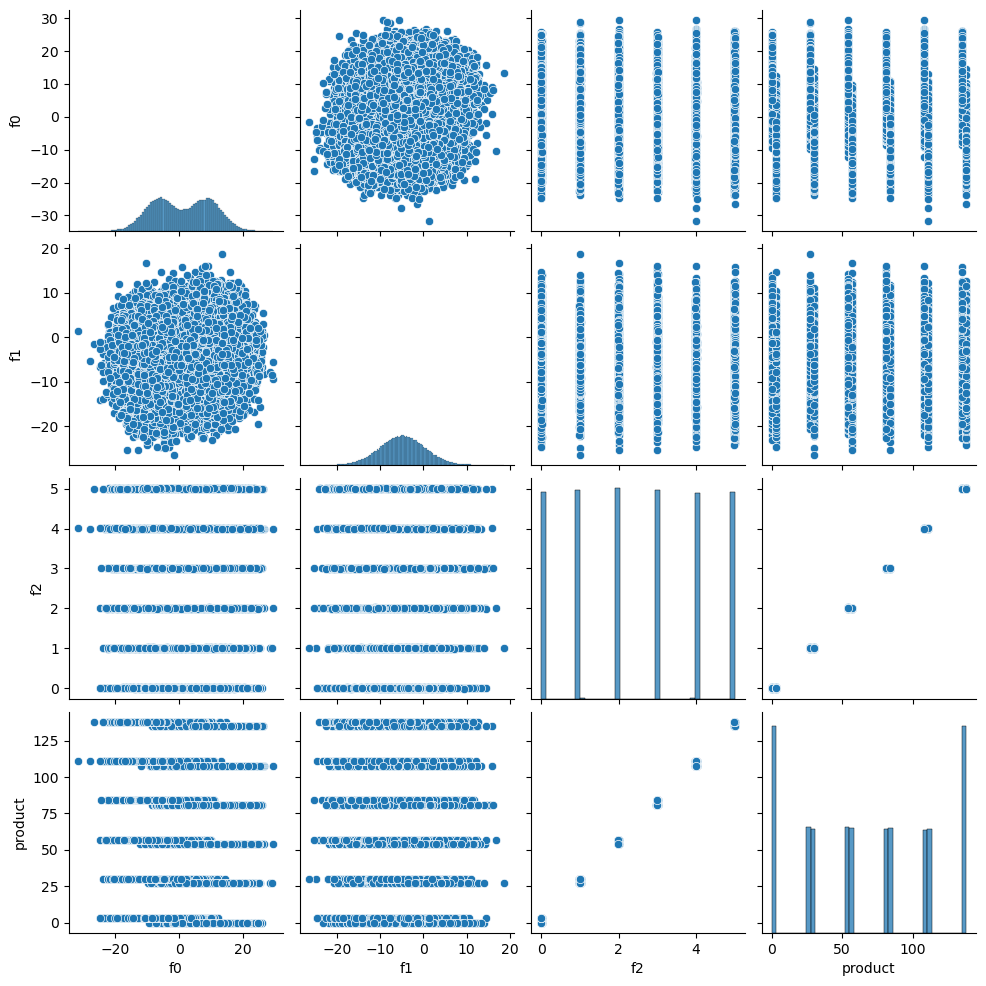

In [11]:
sb.heatmap(geo_data_1.drop('id', axis=1).corr(), cmap='flare', annot=True)
plt.show()
sb.pairplot(geo_data_1)
plt.show()

We could remove the f2 column here, but linear regression seems to predict this region perfectly well as it is.

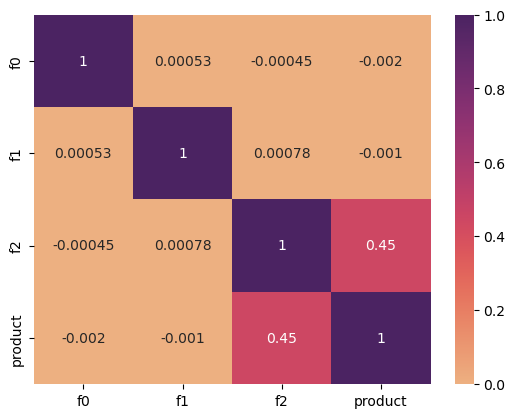

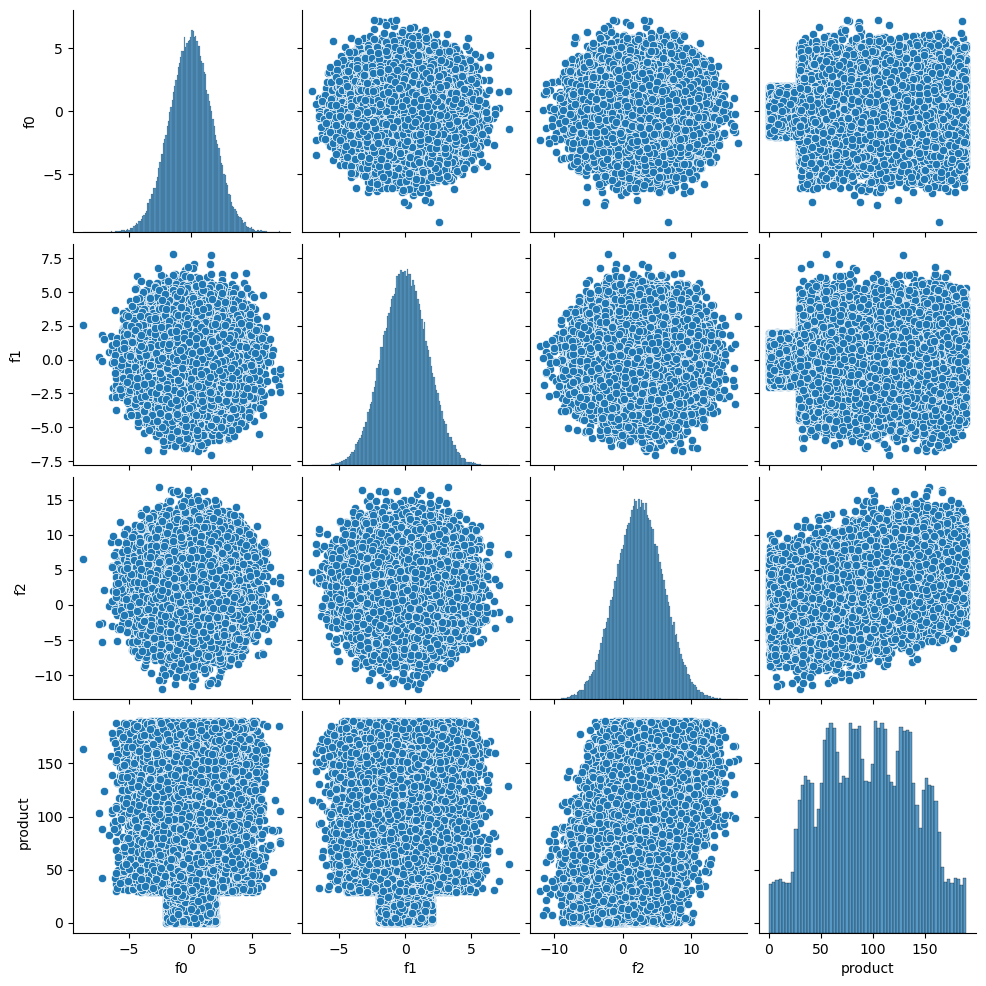

In [12]:
sb.heatmap(geo_data_2.drop('id', axis=1).corr(), cmap='flare', annot=True)
plt.show()
sb.pairplot(geo_data_2)
plt.show()

There's also a correlation of 0.45 between f2 and product.

### Normality

Let's check the normality of the data distribution.

In [13]:
sample_data = geo_data_1['f1']
print(sample_data.name)
print('Shapiro-Wilk test:')
print(shapiro(sample_data));
if shapiro(sample_data).pvalue < 0.05:
    print('This data is not from a normal distribution')
else:
    print('This data may be from a normal distribution')
print()
print('Kolmogorov-Smirnov test:')
print(kstest(sample_data, 'norm'));
if kstest(sample_data, 'norm').pvalue < 0.05:
    print('This data is not from a normal distribution')
else:
    print('This data may be from a normal distribution')

f1
Shapiro-Wilk test:
ShapiroResult(statistic=0.9999602437019348, pvalue=0.2935238778591156)
This data may be from a normal distribution

Kolmogorov-Smirnov test:
KstestResult(statistic=0.6853550799694432, pvalue=0.0)
This data is not from a normal distribution


/home/leonid/anaconda3/envs/practicum/lib/python3.9/site-packages/scipy/stats/_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


We first check them for the generated distributions:

#### Histograms for generation

Normal distribution

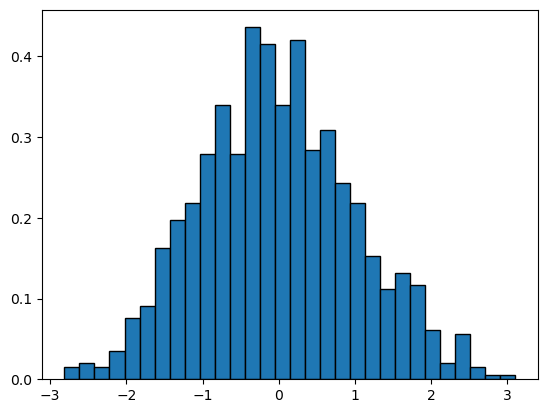

In [14]:
np.random.seed(57) # operates in a single cell

# norm_data = np.random.normal(size=1000)
norm_data = norm.rvs(loc=0, scale=1, size=1000)
# mean 0, standard deviation 1

plt.hist(norm_data, density=True, bins=30, edgecolor='black');

Lognormal distribution, i.e. $X = e^Y$, where $Y$ is a normally distributed random variable:

$X \backsim  LogN(\mu, \sigma^2) \rightarrow Y = \ln(X) \backsim N(\mu, \sigma^2)$

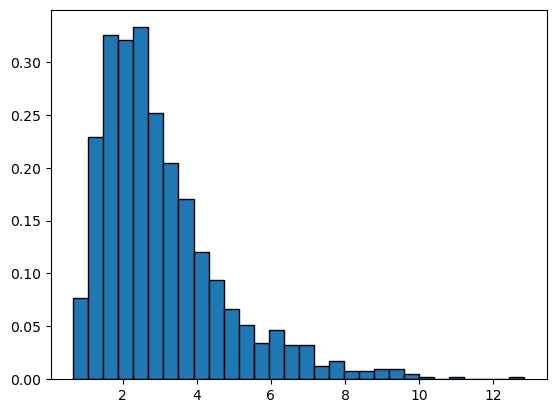

In [15]:
np.random.seed(57)

# lognorm_data = np.random.lognormal(size=1000)
lognorm_data = lognorm.rvs(s=0.5, scale=math.exp(1), size=1000)
# mean 1, standard deviation 0.5
plt.hist(lognorm_data, density=True, bins=30, edgecolor='black');

#### QQ-plot for generation

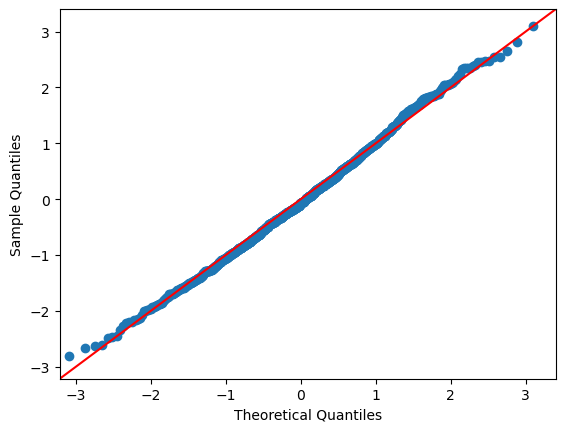

In [16]:
sm.qqplot(norm_data, line='45');

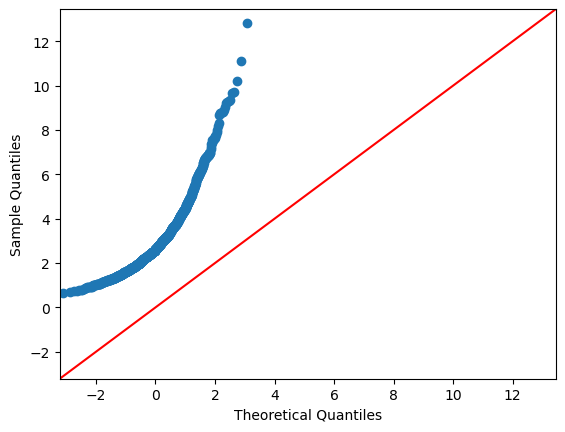

In [17]:
sm.qqplot(lognorm_data, line='45');

#### Shapiro-Wilk test for generation

$H_0$: data from a normal distribution<br>
$H_1$: data not from a normal distribution

In [18]:
print('Normal data')
print('p-value:', shapiro(norm_data).pvalue)
if shapiro(norm_data).pvalue < 0.05:
    print('This data is not from a normal distribution')
else:
    print('This data is from a normal distribution')

Normal data
p-value: 0.030226966366171837
This data is not from a normal distribution


In [19]:
print('Lognormal data')
print('p-value:', shapiro(lognorm_data).pvalue)
if shapiro(lognorm_data).pvalue < 0.05:
    print('This data is not from a normal distribution')
else:
    print('This data is from a normal distribution')

Lognormal data
p-value: 9.582553031076134e-28
This data is not from a normal distribution


As you can see, the test was wrong (if generated correctly). The sample size is sufficient and the threshold is the most common. On the [test page](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html) it is writtent that it makes a type I mistake (i.e. ours) with a 5% probability.

#### Kolmogorov-Smirnov test for generation

$H_0$: data from the selected distribution<br>
$H_1$: data not from a selected distribution

With [this test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html) it is also possible to test the hypothesis that the two samples are drawn from the same distribution.

In [20]:
print('Normal data')
print('p-value:', kstest(norm_data, 'norm').pvalue)
if kstest(norm_data, 'norm').pvalue < 0.05:
    print('This data is not from a normal distribution')
else:
    print('This data is from a normal distribution')

Normal data
p-value: 0.1006234841319138
This data is from a normal distribution


In [21]:
print('Lognormal data')
print('p-value:', kstest(lognorm_data, 'norm').pvalue)
if kstest(lognorm_data, 'norm').pvalue < 0.05:
    print('This data is not from a normal distribution')
else:
    print('This data is from a normal distribution')

Lognormal data
p-value: 0.0
This data is not from a normal distribution


#### Anderson-Darling test for generation

$H_0$: the data follow a normal distribution<br>
$H_1$: the data do not follow a normal distribution

If the test statistic is above the critical value, we reject the null hypothesis (the data are not normally distributed).

In [22]:
print('Normal data')
anderson_result = anderson(norm_data, dist='norm')
print(anderson_result.statistic)
for i in range(len(anderson_result.critical_values)):
    if anderson_result.statistic < anderson_result.critical_values[i]:
        print('{}%:, {}, failed to reject H0'.format(anderson_result.significance_level[i], 
                                                     anderson_result.critical_values[i]))
    else:
        print('{}%:, {}, reject H0'.format(anderson_result.significance_level[i], 
                                           anderson_result.critical_values[i]))        

Normal data
0.7547887835079337
15.0%:, 0.574, reject H0
10.0%:, 0.653, reject H0
5.0%:, 0.784, failed to reject H0
2.5%:, 0.914, failed to reject H0
1.0%:, 1.088, failed to reject H0


In [23]:
print('Lognormal data')
anderson_result = anderson(lognorm_data, dist='norm')
print(anderson_result.statistic)
for i in range(len(anderson_result.critical_values)):
    if anderson_result.statistic < anderson_result.critical_values[i]:
        print('{}%:, {}, failed to reject H0'.format(anderson_result.significance_level[i], 
                                                     anderson_result.critical_values[i]))
    else:
        print('{}%:, {}, reject H0'.format(anderson_result.significance_level[i], 
                                           anderson_result.critical_values[i]))      

Lognormal data
32.65230347189299
15.0%:, 0.574, reject H0
10.0%:, 0.653, reject H0
5.0%:, 0.784, reject H0
2.5%:, 0.914, reject H0
1.0%:, 1.088, reject H0


#### Histogram for data

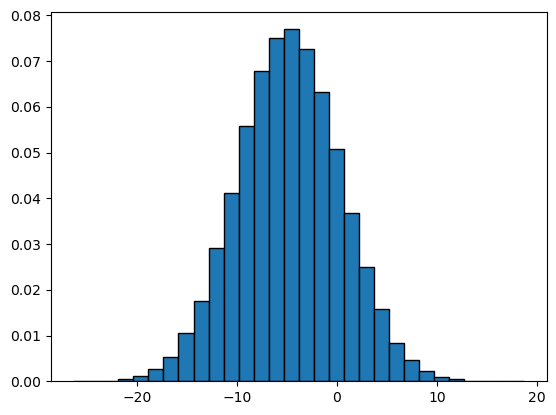

In [24]:
sample_data = geo_data_1['f1']
plt.hist(sample_data, density=True, bins=30, edgecolor='black');

Looks normal.

#### QQ-plot for data

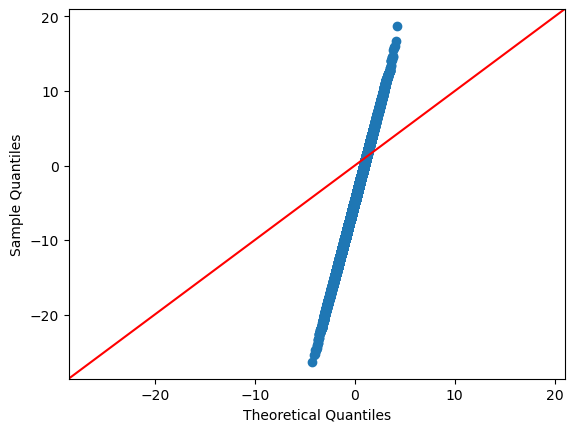

In [25]:
sm.qqplot(sample_data, line='45');

That's probably because they're not [standardized](https://deepchecks.com/glossary/normalization-in-machine-learning/).

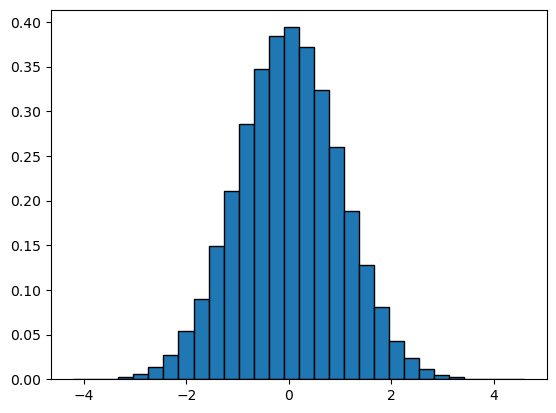

In [26]:
plt.hist(zscore(sample_data), density=True, bins=30, edgecolor='black'); # standardization

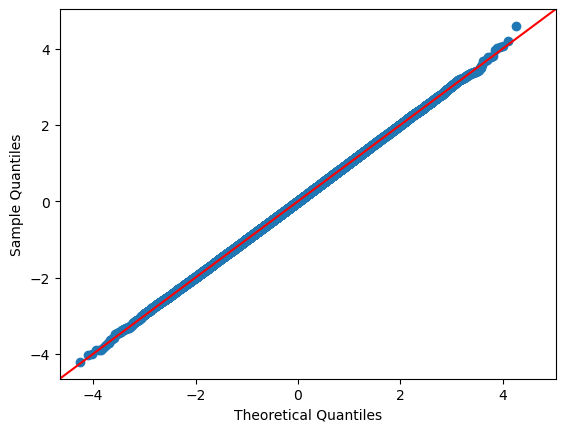

In [27]:
sm.qqplot(zscore(sample_data), line='45');

#### Shapiro-Wilk test for data

In [28]:
print('p-value:', shapiro(sample_data).pvalue)
if shapiro(sample_data).pvalue < 0.05:
    print('This data is not from a normal distribution')
else:
    print('This data is from a normal distribution')

p-value: 0.2935238778591156
This data is from a normal distribution


#### Kolmogorov-Smirnov test for data

In [29]:
print('p-value:', kstest(sample_data, 'norm').pvalue)
if kstest(sample_data, 'norm').pvalue < 0.05:
    print('This data is not from a normal distribution')
else:
    print('This data is from a normal distribution')

p-value: 0.0
This data is not from a normal distribution


The data is really unlikely to be from $X \backsim N(0, 1)$

In [30]:
print('p-value:', kstest(zscore(sample_data), 'norm').pvalue)
if kstest(zscore(sample_data), 'norm').pvalue < 0.05:
    print('This data is not from a normal distribution')
else:
    print('This data is from a normal distribution')

p-value: 0.6234450437006991
This data is from a normal distribution


#### Anderson-Darling test for data

In [31]:
anderson_result = anderson(sample_data, dist='norm')
print(anderson_result.statistic)
for i in range(len(anderson_result.critical_values)):
    if anderson_result.statistic < anderson_result.critical_values[i]:
        print('{}%:, {}, failed to reject H0'.format(anderson_result.significance_level[i], 
                                                     anderson_result.critical_values[i]))
    else:
        print('{}%:, {}, reject H0'.format(anderson_result.significance_level[i], 
                                           anderson_result.critical_values[i]))      

0.6486431970843114
15.0%:, 0.576, reject H0
10.0%:, 0.656, failed to reject H0
5.0%:, 0.787, failed to reject H0
2.5%:, 0.918, failed to reject H0
1.0%:, 1.092, failed to reject H0


It turns out the data are normally distributed but not standardized, so the tests diverged the first time. Nevertheless, the Shapiro-Wilk test was wrong.

### Scaling

In [32]:
all_data.describe()

,f0,f1,f2,product
count,300000.000000,300000.000000,300000.000000,300000.000000
mean,0.547913,-1.516172,2.497439,85.441667
std,5.316634,3.900220,2.916502,46.519494
min,-31.609576,-26.358598,-12.088328,0.000000
25%,-1.003037,-2.478939,0.648213,52.666629
50%,0.347934,-0.229632,2.491215,84.038886
75%,1.755365,0.678562,4.344943,124.174086
max,29.421755,18.734063,16.739402,190.029838


Apparently, the data are already scaled. In any case, there are no significant differences between the characteristics of the points (judging by the minima and maxima).

## Samples

Since we only need the model for this data, there is no point in a test sample.

In [33]:
geo_data = {0: geo_data_0, 1: geo_data_1, 2: geo_data_2}

In [34]:
geo_data[1]

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
...,...,...,...,...,...
99995,QywKC,9.535637,-6.878139,1.998296,53.906522
99996,ptvty,-10.160631,-12.558096,5.005581,137.945408
99997,09gWa,-7.378891,-3.084104,4.998651,137.945408
99998,rqwUm,0.665714,-6.152593,1.000146,30.132364


In [35]:
features = {}
target = {}
for i in 0, 1, 2:
    features[i] = geo_data[i].drop(['id', 'product'], axis=1)
    # instead of id we will use the index
    target[i] = geo_data[i]['product']

In [36]:
features[0]

,f0,f1,f2
0,0.705745,-0.497823,1.221170
1,1.334711,-0.340164,4.365080
2,1.022732,0.151990,1.419926
3,-0.032172,0.139033,2.978566
4,1.988431,0.155413,4.751769
...,...,...,...
99995,0.971957,0.370953,6.075346
99996,1.392429,-0.382606,1.273912
99997,1.029585,0.018787,-1.348308
99998,0.998163,-0.528582,1.583869


In [37]:
features_train = {}
features_valid = {}
target_train = {}
target_valid = {}
for i in 0, 1, 2:
    features_train[i], features_valid[i], target_train[i], target_valid[i] = \
    train_test_split(features[i], target[i], random_state=57)

In [38]:
features_train[1]

,f0,f1,f2
97501,1.483372,-4.720276,3.002467
75725,-5.263973,-15.357834,0.992973
10748,1.697558,-9.747678,4.002124
45676,-6.765353,-5.839270,4.994510
46340,-11.272433,-0.184906,-0.002780
...,...,...,...
19064,-9.250584,-11.507806,1.003149
85071,-15.363442,-7.104400,1.993658
35845,7.207165,-0.017085,1.010123
11990,11.956859,-7.401173,4.996352


In [39]:
target_valid[2]

83880     66.355179
72252     76.198012
65978    154.412190
85274    113.635346
21258     90.557191
            ...    
4336      57.150975
18981     83.608810
11359     63.672303
3786      83.237629
17683    135.023129
Name: product, Length: 25000, dtype: float64

## Training

In [40]:
predictions_valid = {}
for i in 0, 1, 2:
    model = LinearRegression()
    model.fit(features_train[i], target_train[i])
    predictions_valid[i] = pd.Series(model.predict(features_valid[i]), name='product_pred')
    predictions_valid[i].index = features_valid[i].index

In [41]:
predictions_valid[0]

83880     72.552657
72252    110.302530
65978     71.880720
85274    116.327736
21258     95.033709
            ...    
4336     108.801470
18981    116.449908
11359     50.202244
3786      80.456068
17683     92.858526
Name: product_pred, Length: 25000, dtype: float64

In [42]:
target_valid[0]

83880     71.033241
72252    103.467670
65978     86.288812
85274     77.519493
21258     55.661946
            ...    
4336     115.183790
18981    137.774053
11359     10.174574
3786     105.811893
17683     98.581907
Name: product, Length: 25000, dtype: float64

In [43]:
for i in 0, 1, 2:
    print('Region:', i)
    print('True mean:', target_valid[i].mean())
    print('Predicted mean:', predictions_valid[i].mean())
    print()
    print('MAE:', mae(target_valid[i], predictions_valid[i]))
    print('RMSE:', mse(target_valid[i], predictions_valid[i], squared=False))
    print('R2:', r2_score(target_valid[i], predictions_valid[i]))
    print()

Region: 0
True mean: 92.52289478897879
Predicted mean: 92.45219024204698

MAE: 30.88607152372649
RMSE: 37.56266445200724
R2: 0.27451410659521136

Region: 1
True mean: 68.78648033443964
Predicted mean: 68.80301891138748

MAE: 0.7178720755020909
RMSE: 0.8895304248365526
R2: 0.9996237751522308

Region: 2
True mean: 94.83766113524678
Predicted mean: 94.95110980489686

MAE: 33.027592410434245
RMSE: 40.3067636097363
R2: 0.1952316762928613



The prediction accuracy for region 1 is immediately striking, but there are fewer stocks there as well.

## Profit calculation

According to the terms of the problem:
- A budget of 10 billion rubles has been allocated for the development. This amount has to be recouped.
- It is possible to drill 200 wells out of the 500 considered.
- For each thousand barrels we get a profit of 450,000 rubles.
- The probability of loss must be less than 2.5%.

In [44]:
TOTAL = 10000000000
PRICE = 450000
NUMBER = 200
SAMPLE = 500
PROBABILITY = 0.025

print(TOTAL / NUMBER / PRICE)

111.11111111111111


This is roughly how many thousands of barrels an average well needs to produce to break even.

When compared to the mean values, it becomes clear that not every point will do.

In [45]:
def revenue(target, predictions):
    target = target.sort_index().reset_index(drop=True)
    predictions = predictions.sort_index().reset_index(drop=True)
    selected = predictions.sort_values(ascending=False)[:NUMBER]
    # print(len(target[selected.index]))
    return target[selected.index].sum() * PRICE - TOTAL

In [46]:
revenue(target_valid[0][:SAMPLE], predictions_valid[0][:SAMPLE])

201627345.91400337

Let's build a profit distribution based on 1000 samples of 500 points.

In [47]:
state = np.random.RandomState(12345)

income = {0: [], 1: [], 2: []}
product = {0: [], 1: [], 2: []}
for data in 0, 1, 2:
    for i in range(1000):
        subsample = predictions_valid[data].sample(SAMPLE, replace=True, random_state=state)
        product[data].append(subsample.sort_values(ascending=False)[:NUMBER])
        income[data].append(revenue(target_valid[data][subsample.index], subsample))
income = pd.DataFrame(income)

The distribution is built on 25% of the data (validation sample).

In [48]:
income.head()

,0,1,2
0,1.740369e+08,5.612207e+08,3.059560e+07
1,4.830754e+07,5.504601e+08,3.715849e+08
2,3.990190e+08,4.620119e+08,5.156360e+08
3,5.627104e+08,4.277398e+08,2.495204e+08
4,1.933146e+08,5.340393e+08,3.872039e+08


In [49]:
product[0][0]

10355    167.130910
91162    152.703153
96253    150.591938
97429    150.519751
40096    147.963906
            ...    
63581     96.634319
92222     96.532565
49251     96.418725
85333     96.341837
74017     96.288065
Name: product_pred, Length: 200, dtype: float64

In [50]:
product[0][0].mean()

113.49554679068015

In [51]:
income[0][0]

174036861.40742683

The first of 3,000 samples paid off at 501 million.

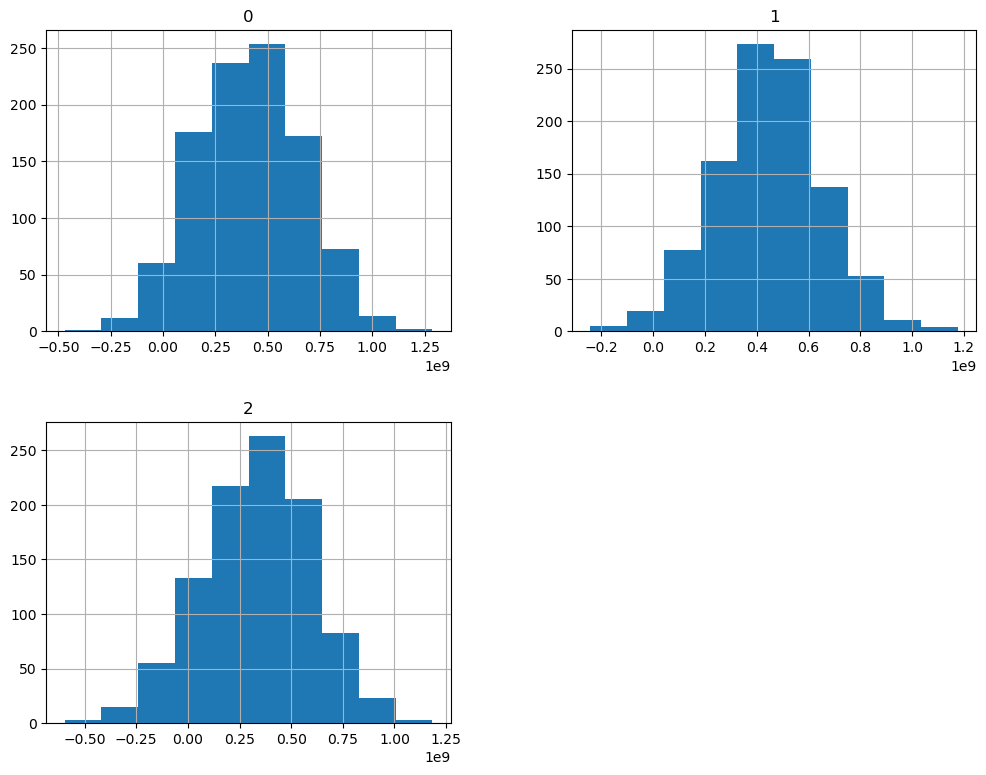

In [52]:
income.hist(figsize=(12, 9));

At first glance, the income is normally distributed.

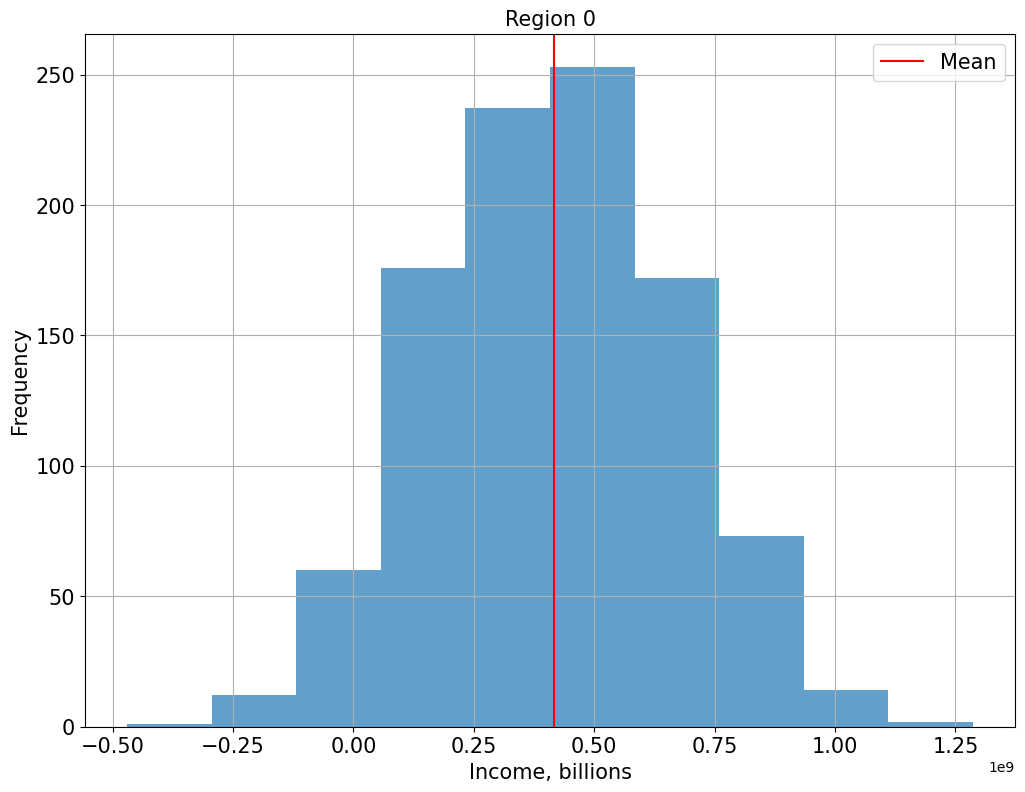

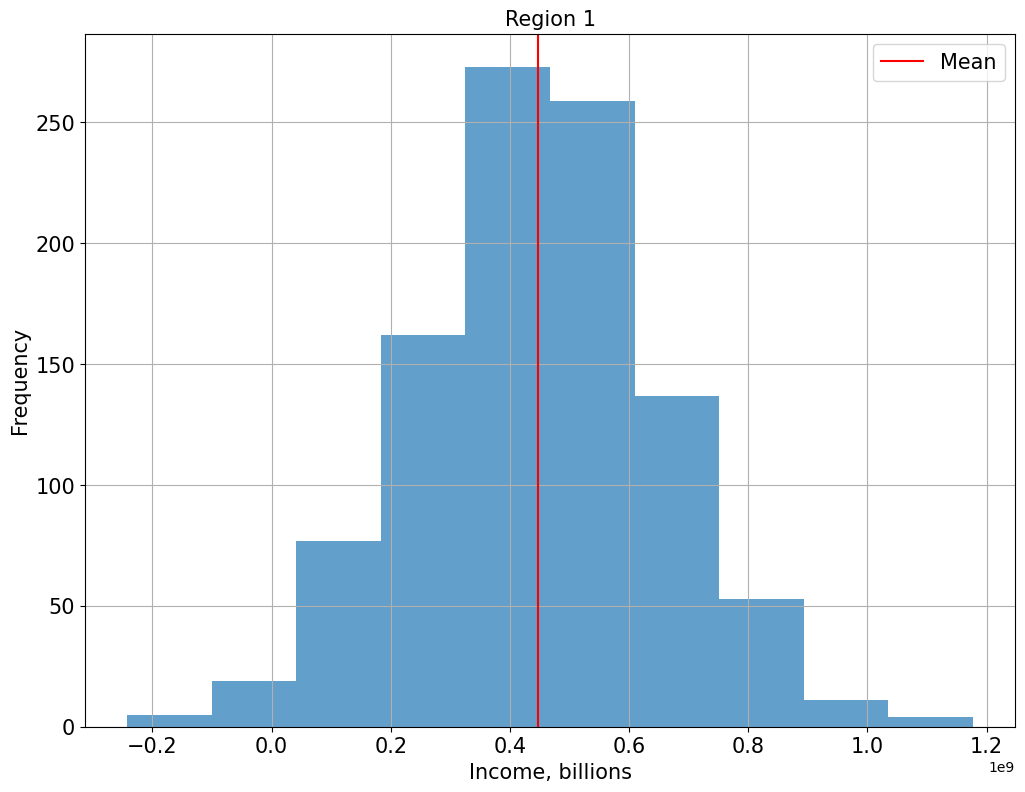

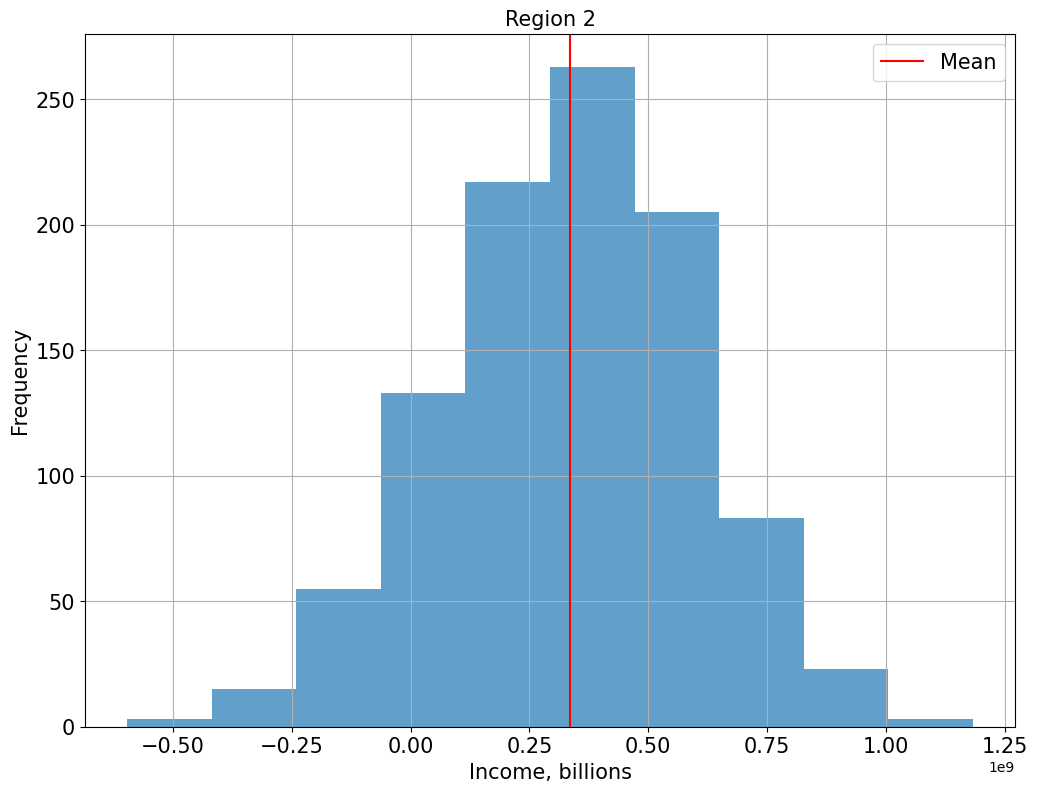

In [53]:
for i in 0, 1, 2:
    income[i].hist(figsize=(12, 9), alpha=0.7)
    plt.axvline(x=income[i].mean(), color='red', label='Mean')
    plt.title('Region {}'.format(i), fontsize=15)
    plt.xlabel('Income, billions', fontsize=15)
    plt.ylabel('Frequency', fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(fontsize=15)
    plt.show()

Let's check this with tests.

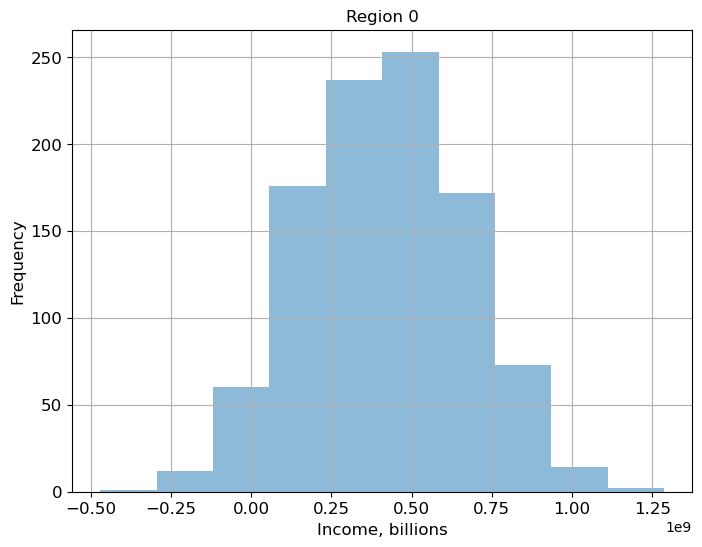

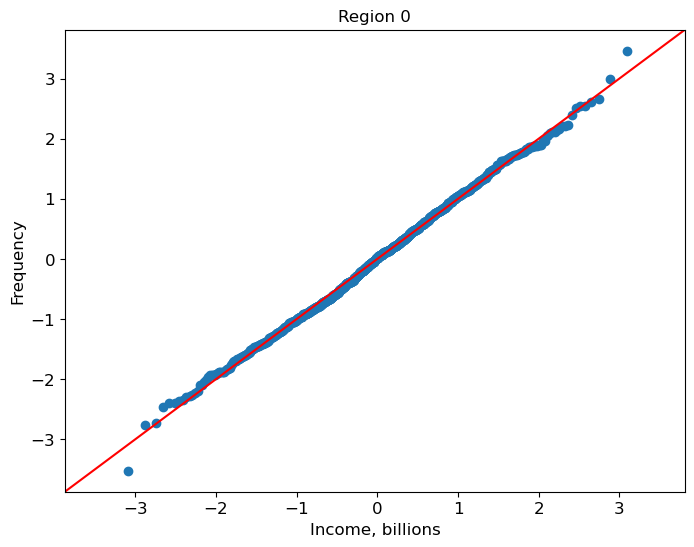

Shapiro-Wilk test: This data is from a normal distribution
(p-value: 0.4682195484638214)
Kolmogorov-Smirnov test: This data is from a normal distribution
(p-value: 0.43782753604817404)
Anderson-Darling test: This data is from a normal distribution
(reject H0, times: 0/5)


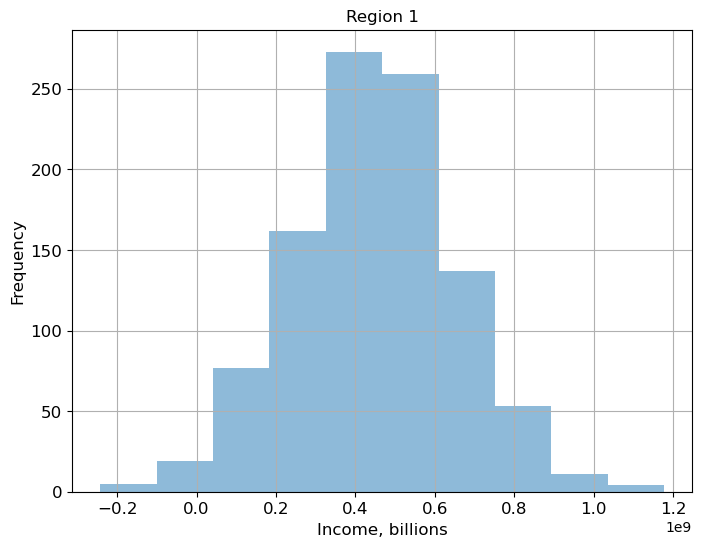

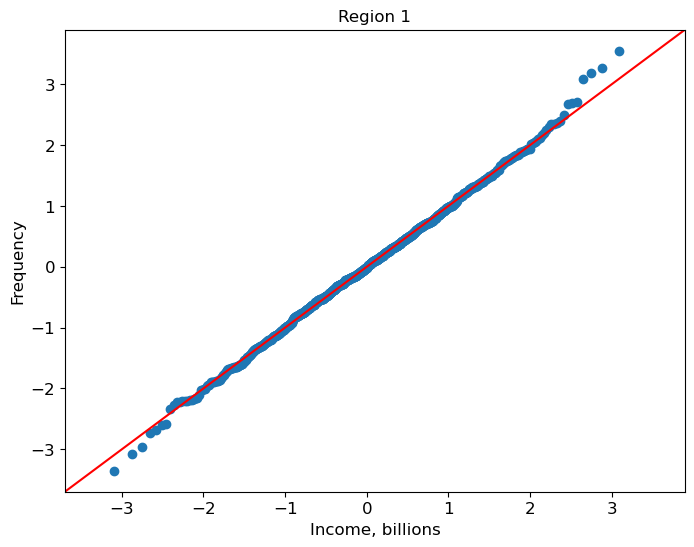

Shapiro-Wilk test: This data is from a normal distribution
(p-value: 0.7872468829154968)
Kolmogorov-Smirnov test: This data is from a normal distribution
(p-value: 0.8589276898110905)
Anderson-Darling test: This data is from a normal distribution
(reject H0, times: 0/5)


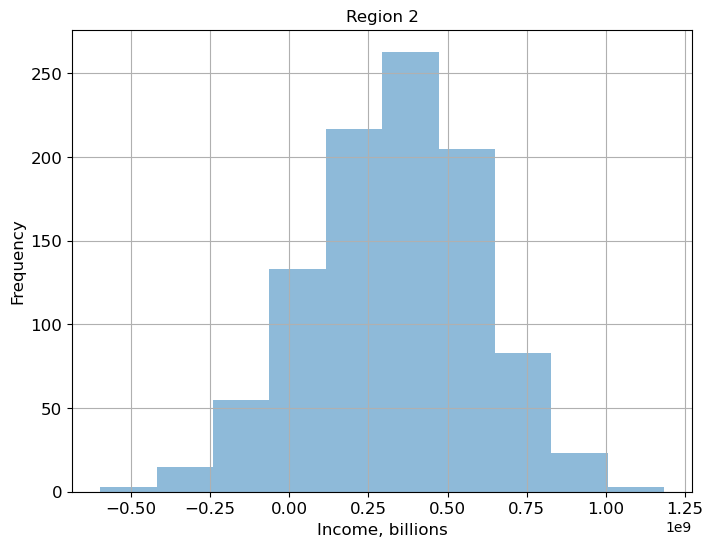

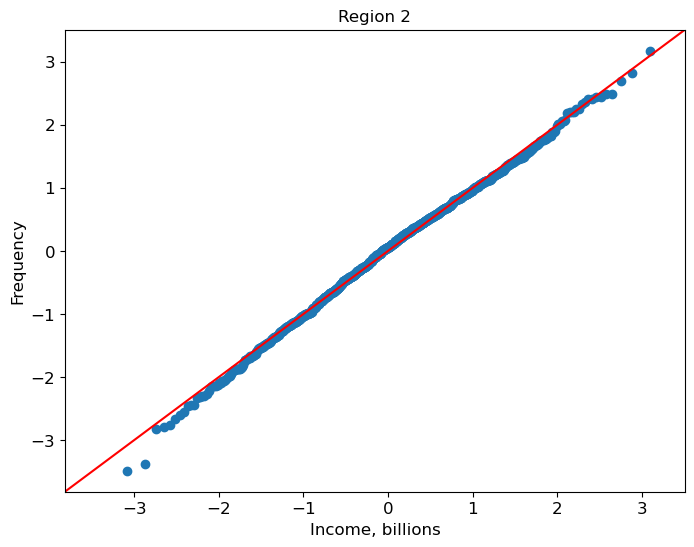

Shapiro-Wilk test: This data is from a normal distribution
(p-value: 0.11885708570480347)
Kolmogorov-Smirnov test: This data is from a normal distribution
(p-value: 0.33005084638144866)
Anderson-Darling test: This data is not from a normal distribution
(reject H0, times: 3/5)


In [54]:
for data in 0, 1, 2:
    income[data].hist(figsize=(8, 6), alpha=0.5)
    plt.title('Region {}'.format(data), fontsize=12)
    plt.xlabel('Income, billions', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()    
    
    
    fig, ax = plt.subplots(figsize=(8, 6))
    sm.qqplot(zscore(income[data]), line='45', ax=ax)   
    plt.title('Region {}'.format(data), fontsize=12)
    plt.xlabel('Income, billions', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show() 
    
    if shapiro(income[data]).pvalue < 0.05:
        print('Shapiro-Wilk test: This data is not from a normal distribution')
        print('(p-value: {})'.format(shapiro(income[data]).pvalue))
    else:
        print('Shapiro-Wilk test: This data is from a normal distribution')
        print('(p-value: {})'.format(shapiro(income[data]).pvalue))
        
    if kstest(zscore(income[data]), 'norm').pvalue < 0.05:
        print('Kolmogorov-Smirnov test: This data is not from a normal distribution')
        print('(p-value: {})'.format(kstest(zscore(income[data]), 'norm').pvalue))
    else:
        print('Kolmogorov-Smirnov test: This data is from a normal distribution')
        print('(p-value: {})'.format(kstest(zscore(income[data]), 'norm').pvalue))
        
    anderson_result = anderson(income[data], dist='norm')
    anderson_votes = []
    for i in range(5):
        anderson_votes.append(anderson_result.statistic > anderson_result.critical_values[i]) 
    anderson_votes = pd.Series(anderson_votes)
    # print(anderson_result)
    if anderson_votes.sum() >= 2:
        print('Anderson-Darling test: This data is not from a normal distribution')
        print('(reject H0, times: {}/5)'.format(int(anderson_votes.sum())))
    else:
        print('Anderson-Darling test: This data is from a normal distribution')
        print('(reject H0, times: {}/5)'.format(int(anderson_votes.sum())))

## Profitability assessment

To select the best region, we compare the mean values, construct a confidence interval and estimate the risks of loss.

### Comparison of mean values

In [55]:
income.mean()

0    4.157042e+08
1    4.470127e+08
2    3.350558e+08
dtype: float64

The first region looks the most profitable. Moreover, the model had high accuracy in this region. However, the average reserves are lower than the other two. Apparently, it is heterogeneous, i.e. there are a lot of both poor and rich points.

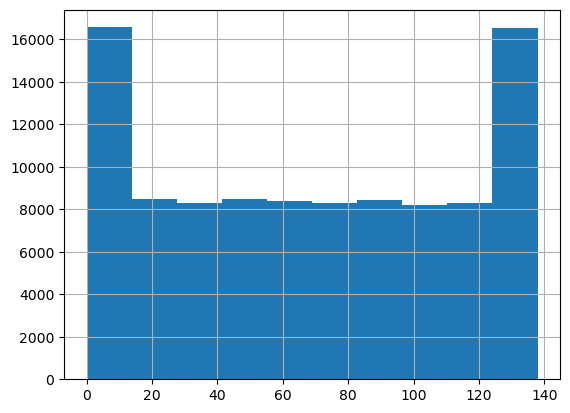

In [56]:
geo_data[1]['product'].hist();

Let's compare it to the other two:

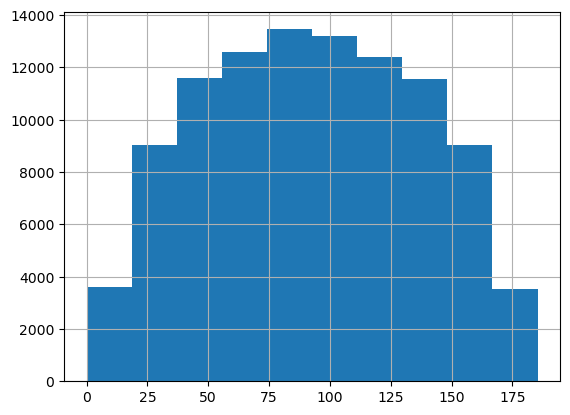

In [57]:
geo_data[0]['product'].hist();

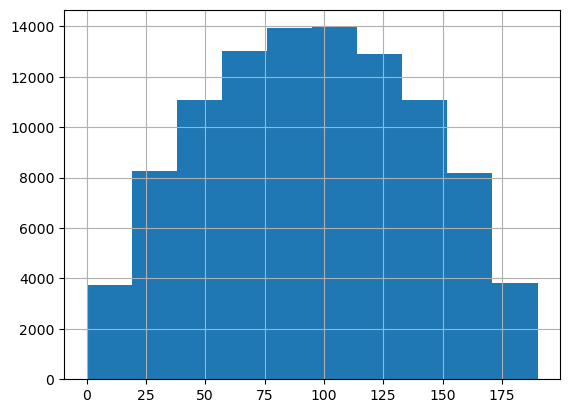

In [58]:
geo_data[2]['product'].hist();

It's all a little suspicious.

In [59]:
geo_data[1]['product'].sort_values(ascending=False)

53864    137.945408
97083    137.945408
88340    137.945408
64879    137.945408
7288     137.945408
            ...    
67767      0.000000
36443      0.000000
36430      0.000000
67776      0.000000
42537      0.000000
Name: product, Length: 100000, dtype: float64

In [60]:
geo_data[1]['product'].value_counts()

53.906522     8472
26.953261     8468
84.038886     8431
57.085625     8390
3.179103      8337
80.859783     8320
30.132364     8306
134.766305    8304
110.992147    8303
0.000000      8235
137.945408    8233
107.813044    8201
Name: product, dtype: int64

In [61]:
geo_data[0]['product'].value_counts()

0.000000      1
30.141653     1
56.573577     1
50.182301     1
88.989990     1
             ..
146.560758    1
155.729658    1
27.829511     1
85.382946     1
154.424007    1
Name: product, Length: 100000, dtype: int64

The statement of the problem says the data is synthetic, but I didn't think it was that much.

### Confidence interval

Let's build the confidence intervals for the income in all three regions based on the bootstrap resamples obtained above. We can either build an interval for the income itself with so-called percentile intervals or calculate the confidence interval for the mean income (assuming that it is normally distributed). 

Confidence intervals for profit, millions
Region 0, percentile bounds for income: (-58.1890014073565, 887.1677696353535)
Region 0, confidence interval bounds for mean income: (400.11992112572364, 431.2883812911256)


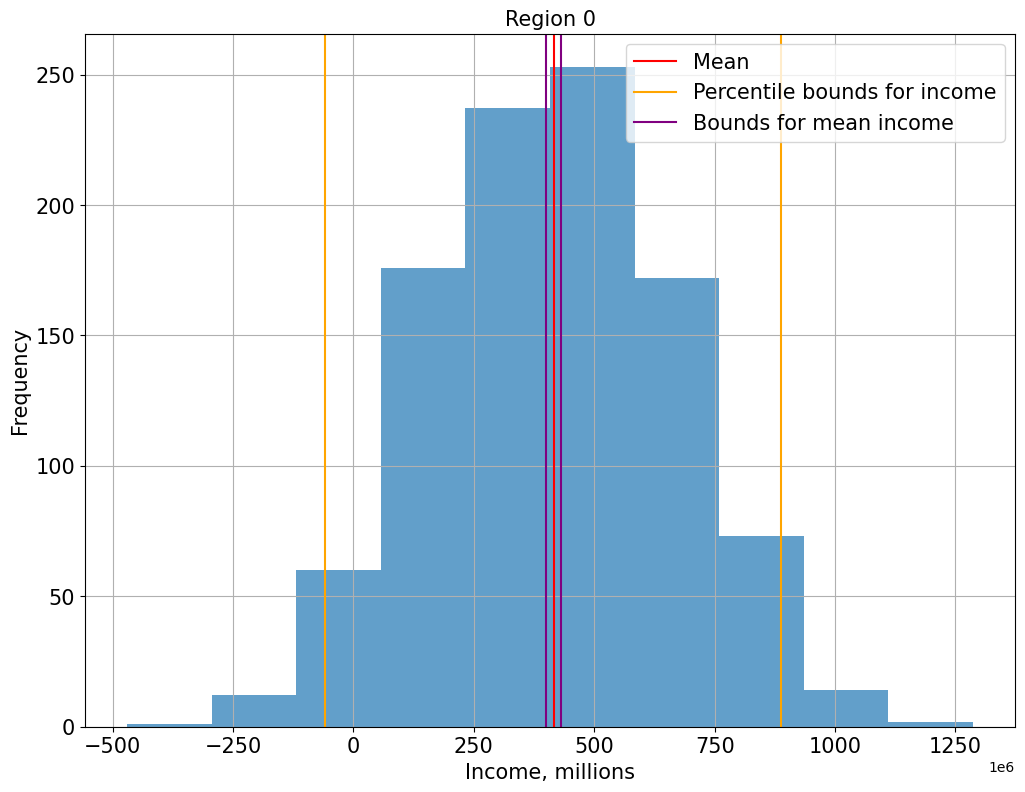

Region 1, percentile bounds for income: (47.440717862944034, 840.21335626002)
Region 1, confidence interval bounds for mean income: (434.2636844512239, 459.7617051807616)


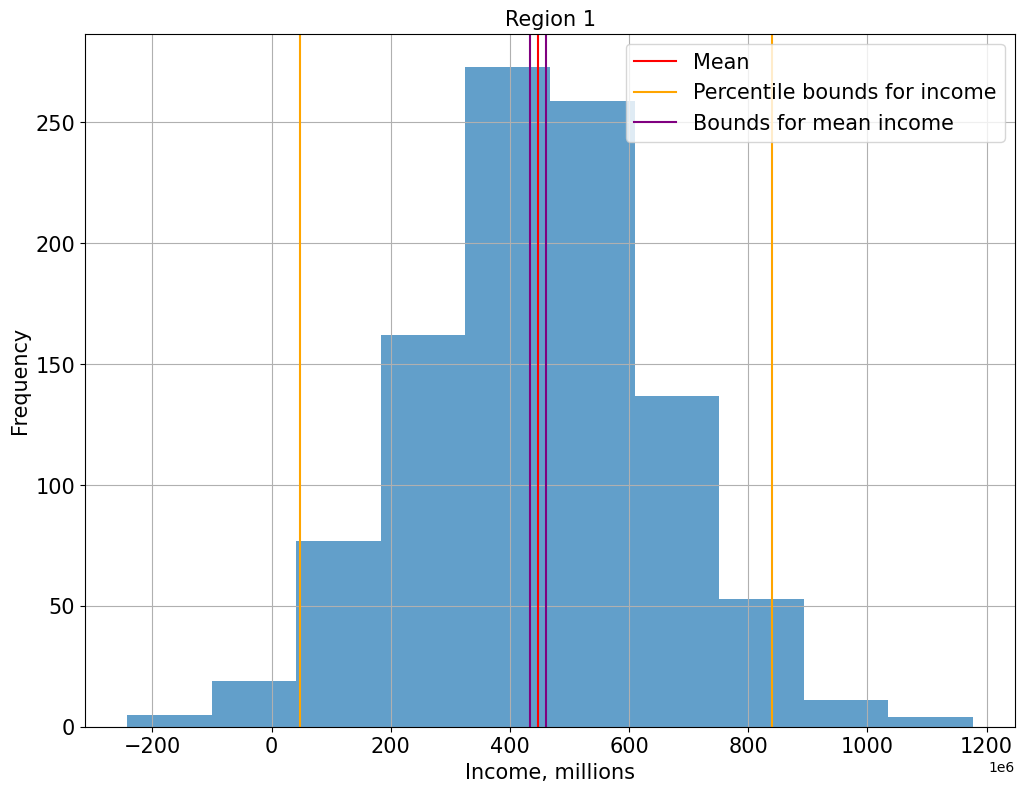

Region 2, percentile bounds for income: (-214.90347517056236, 839.2865764431807)
Region 2, confidence interval bounds for mean income: (318.4947845594229, 351.61673876210995)


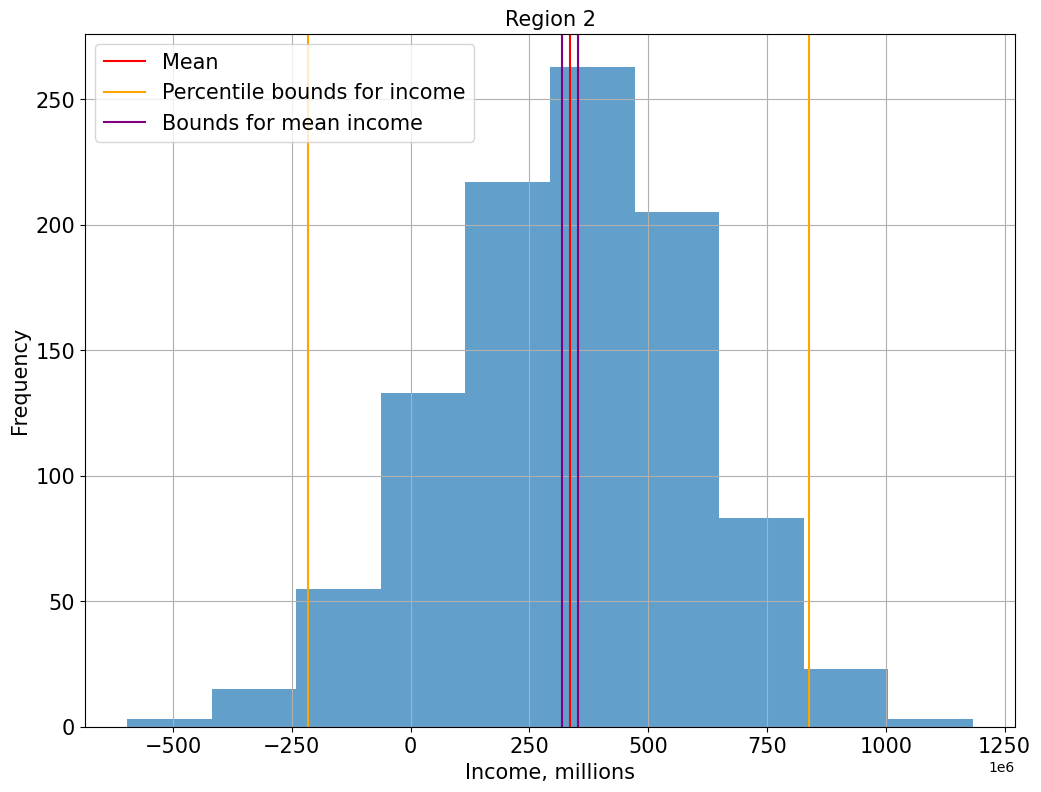

In [62]:
print('Confidence intervals for profit, millions')
for data in 0, 1, 2:
    
    # percentile interval for income
    income_left_border, income_right_border = (income[data].quantile(0.025), 
                                               income[data].quantile(0.975))
    # confidence interval bounds for mean income 
    mean_income_left_border, mean_income_right_border = st.norm.interval(
        0.95, loc=income[data].mean(), scale=income[data].sem())
    
    print('Region {}, percentile bounds for income:'.format(data), 
          (income_left_border / 1000000, income_right_border / 1000000))
    print('Region {}, confidence interval bounds for mean income:'.format(data), 
          (mean_income_left_border / 1000000, mean_income_right_border / 1000000))

    income[data].hist(figsize=(12, 9), alpha=0.7)
    
    plt.axvline(x=income[data].mean(), color='red', label='Mean')
    plt.axvline(x=income_left_border, color='orange', label='Percentile bounds for income')
    plt.axvline(x=income_right_border, color='orange')
    plt.axvline(x=mean_income_left_border, color='purple', label='Bounds for mean income')
    plt.axvline(x=mean_income_right_border, color='purple')
    
    plt.title('Region {}'.format(data), fontsize=15)
    plt.xlabel('Income, millions', fontsize=15)
    plt.ylabel('Frequency', fontsize=15)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(6,6))
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(fontsize=15)
    plt.show()

I think the percentile intervals make more sense for the income estimation, taken into account the bootstrap evaluation approach.

### Risk of loss

Let's find for each region the ratio of unprofitable samples to all samples:

In [63]:
for i in 0, 1, 2:
    print('Fraction for the region {}:'.format(i), len(income[i].loc[income[i] < 0]) / len(income)) 

Fraction for the region 0: 0.044
Fraction for the region 1: 0.016
Fraction for the region 2: 0.107


In [64]:
(income < 0).mean()

0    0.044
1    0.016
2    0.107
dtype: float64

The risk of losses for the second region is higher than the threshold (4.9%), so we should choose between the first and the zero region. The average income in the first region is slightly higher, but the data there are distributed in an unnatural way. If it turns out that they were obtained in a way that does not reflect reality, we should switch to the zero region, where the data are distributed more or less normally.

## Conclusions

1. Data specifications
- There are 49 repeating identifiers among the data. Not many, but we still need to understand where the repetitions come from.
- The oil volume in regions 0 and 2 is distributed close to normal, while in the first region the distribution is more like a uniform distribution with outliers.
2. Statistics
- The average oil reserves in region 1 are less than 70 thousand barrels, while in region 0 and 2 they are more than 90 thousand barrels.
- The linear regression perfectly predicts oil volumes in region 1 (expectedly, given the distribution), while for the other two it works worse (RMSE about 40 thousand barrels).
- The average profit is maximized for the samples of the first region (447 million), followed by the zero region (416 million), then the second one (335 million).
3. Issues and recommendations
- The highest risk of loss is for the second region. It is 10.7%. Region zero is noticeably safer (4.4%). The lowest risks are predicted for the first region (1.6%), which, however, may not reflect reality.
- The nature of the data for the first region raises questions. In fact, there are 12 numbers duplicated about 8,000 times. This is implausible and needs to be clarified to make the right business decision.
- Based on all of the above, I suggest choosing the **zero** region for development. If it suddenly turns out that the numbers on oil reserves in the first region are plausible, then we can choose it, as there are slightly higher profits and lower risks.